
# Problem Set 2 


**`PLEASE RUN IN GOOGLE-COLAB`**

**Name : `G.Maneesh Kumar`** 

**Roll-No : `18CS10020`** 

**Dept : `Computer Science and Engineering`** 

**Mail-ID : `manishkumargunda@gmail.com`** 

## Preamble

To run and solve this assignment, one must have a working IPython Notebook installation. The easiest way to set it up for both Windows and Linux is to install [Anaconda](https://docs.anaconda.com/anaconda/install/). Then save this file to your computer, run Anaconda and choose this file in Anaconda's file explorer. Use `Python 3` version. Below statements assume that you have already followed these instructions. If you are new to Python or its scientific library, Numpy, there are some nice tutorials [here](https://www.learnpython.org/) and [here](http://www.scipy-lectures.org/).

Put your solution into boxes marked with **`[double click here to add a solution]`** and press Ctr+Enter to render text. None of the parts of this assignment require use of a machine with a GPU. You may complete the assignment using your local machine or you may use Google Colaboratory.

We highly encourage students to put down their answers to theoretical questions into corresponding cells below. However, if one does not know LaTeX (and would find it too hard to learn it), he/she can write it in pen-and-paper format and submit the scanned pdf. Note that the solutions to the programming problems should be submitted in the ipynb file itself.

Submission instructions: Please upload your completed solution file to [KGP Moodle](https://kgpmoodle.iitkgp.ac.in/moodle/login/index.php) by the due date.

### Problem 1: Gradient Descent Update Rule

**Q1.1**: In learning neural networks, we typically minimize a loss function $\mathcal{L}(w)$ with respect to the network parameters $w$. It is also important that we *regularize* the network to reduce overfitting. A simple and popular regularization strategy is to penalize some *norm* of $w$.

Consider that we have $N$ examples $(x_1, y_1), (x_2, y_2), ..., (x_N, y_N)$ such that $x_i \in \mathbb{R}^d$ and $y_i \in \{-1, 1\}, i = 1...N$. Also consider that we have at our disposal a single neuron. Let $w = [w_1, w_2, ..., w_d]^T$ be the weight vector and the output be given by $\hat y_i = tanh(w.x_i)$. The loss function is given by: $\sum_{i=1}^N l(y_i, \hat y_i) + \lambda \|w\|^2$ where $\lambda$ is the weight of regularization. Derive the update rule for minimizing this loss using stochastic gradient descent with step size $\eta$ when $l(y_i, \hat y_i) = log_e(1 + exp(-y_i. \hat y_i))$. In other words, at time $t+1$, express the new parameters $w_{t+1}$ in terms of the old parameters $w_t$. **[10 marks]**

 

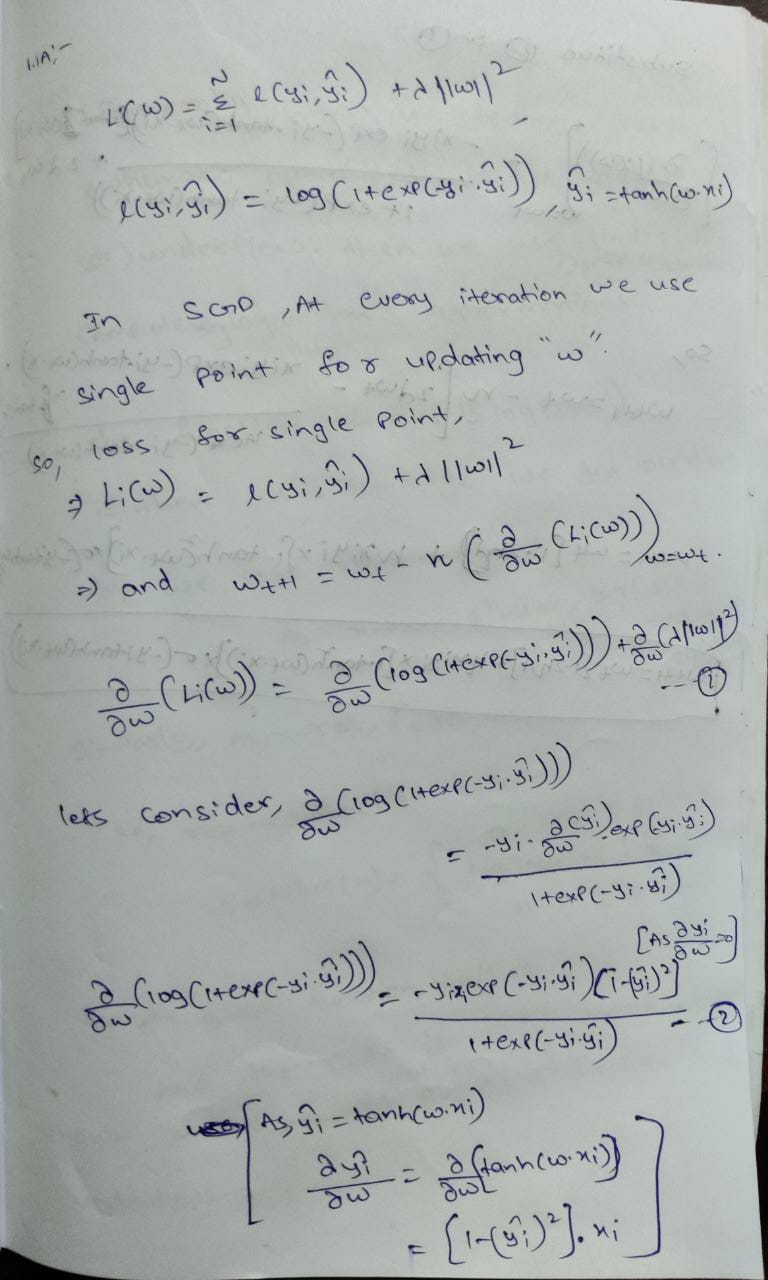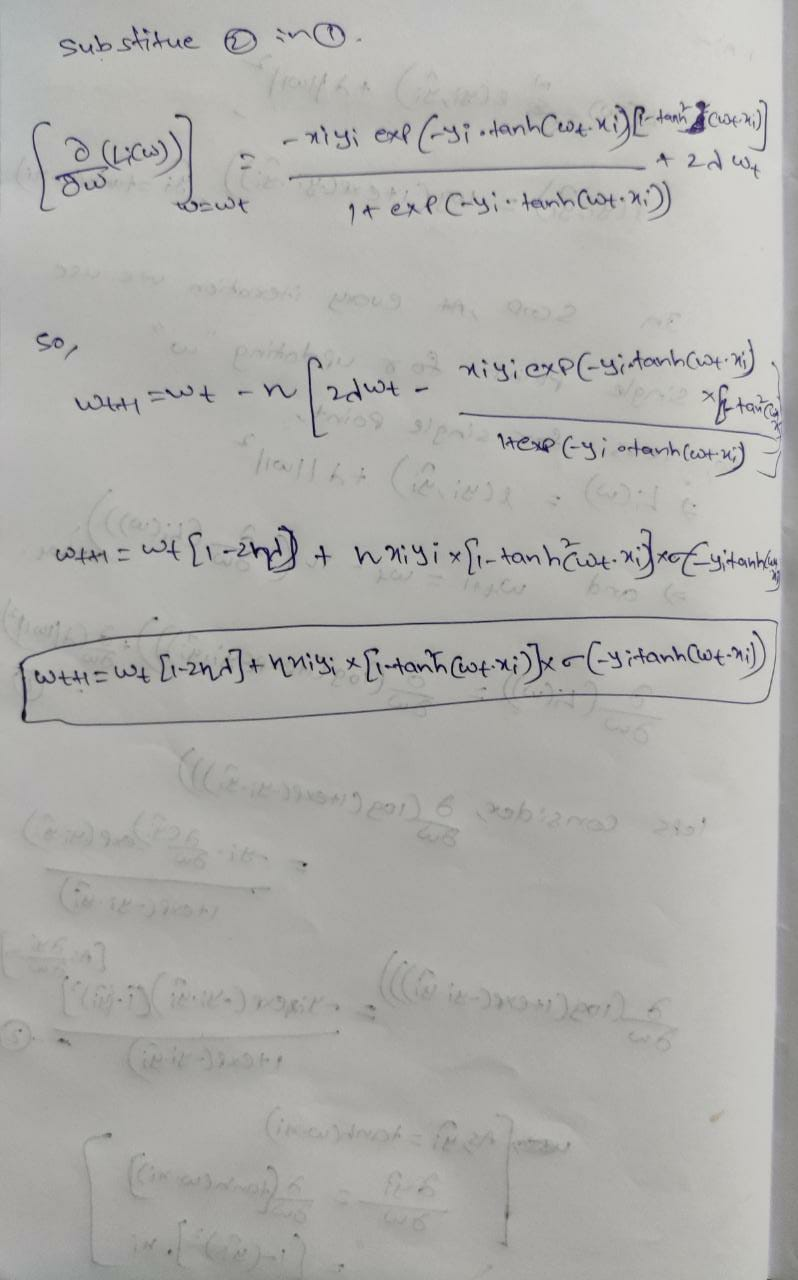

### Problem 2: Numerical Overflow and Underflow

Run the cell below. Is the output the same as that you would expect? This is due to the condition which is called [numerical underflow](https://en.wikipedia.org/wiki/Arithmetic_underflow). It is the condition that occurs when the true result of a floating point operation is smaller in magnitude than the smallest value representable as a normal floating point number in the target datatype.

In [139]:
1e10+1e-10 == 1e10

True

Run the cell below. The warning message must have the word 'overflow' in it. This condition that occurs when a calculation produces a result that is greater in magnitude than the largest value representable in the target datatype is called [numerical overflow](https://en.wikipedia.org/wiki/Integer_overflow).

In [140]:
import numpy as np
np.exp(1000) == np.inf

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


True

**Q2.1**: How do people deal with numerical overflow and underflow? Why have we implemented $\text{softplus}(x) = \log(1+\exp(x))$ as shown in the cell below? **[5 marks]**

In [141]:
import numpy as np

def softplus(x_, limit=5):
    x = np.array(x_)
    compute_real_mask = np.logical_and(-limit < x, x < limit)
    return_same_mask = x >= limit
    computed_real_part = np.log(1 + np.exp(x*compute_real_mask)*compute_real_mask)
    returned_same_part = x*return_same_mask
    return computed_real_part + returned_same_part

def test_softplus():
    x_arr = np.linspace(-200, 200)
    softplus_true = np.log(1 + np.exp(x_arr))
    softplus_stable = softplus(x_arr)
    assert np.max(abs(softplus_true-softplus_stable)) < 1e-3
    
test_softplus()

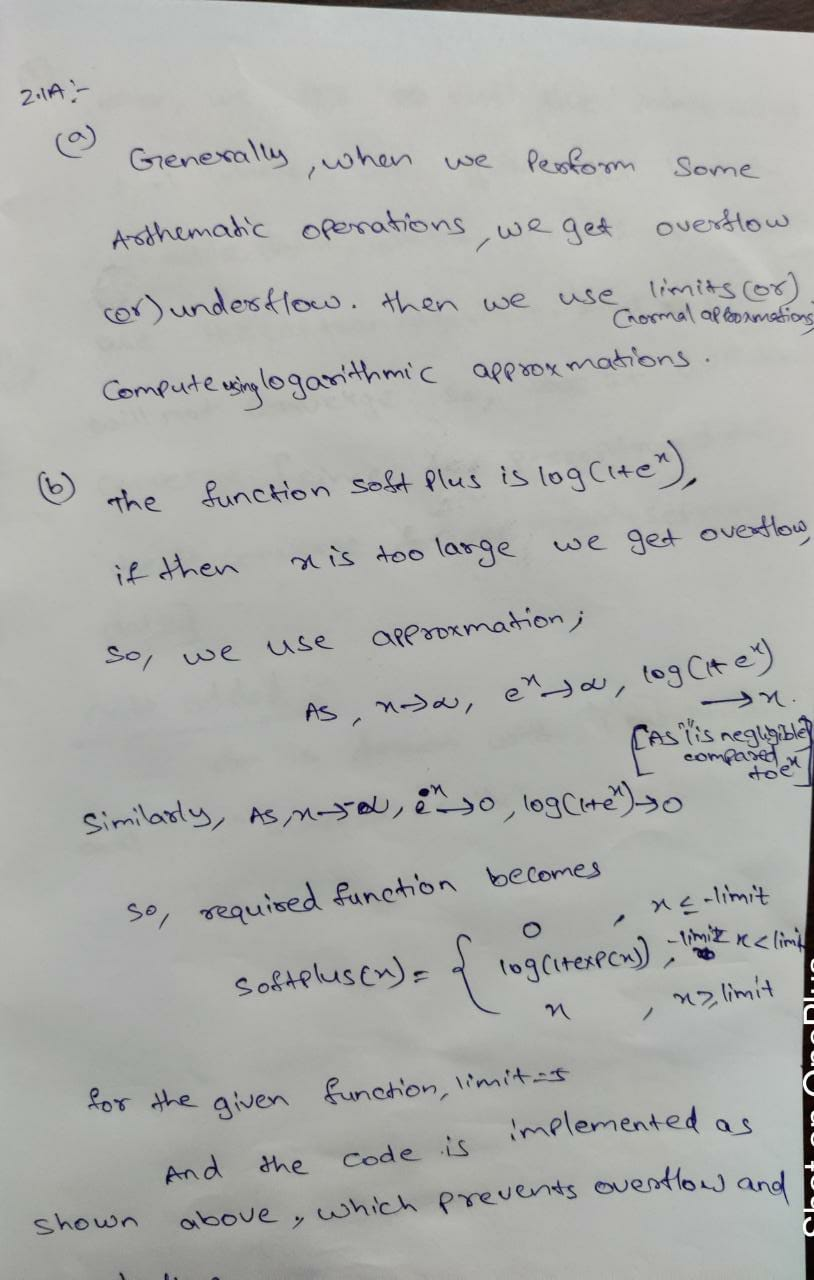

### Problem 3: Perceptron Learning Algorithm

**Q3.1**: The code below generates $n$ 2D data points according to the Gaussian distribution $X1 \sim \mathcal{N}([1,0],\,I_{2\times2})$ and assigns them label 1. It also generates another $n$ 2D data points according to the Gaussian distribution $X2 \sim \mathcal{N}([-1,0],\,I_{2\times2})$ and assigns them label -1.

If perceptron learning algorithm is used to classify the data, will it converge? You may add a code cell to answer this question.   **[5 marks]**

In [142]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

def generate_data(n):
    '''Generate synthetic data'''
    
    X1 = np.random.multivariate_normal([1,0], [[1,0],[0,1]], n)
    X2 = np.random.multivariate_normal([-1,0], [[1,0],[0,1]], n)
    X = np.vstack((X1, X2))

    y1 = np.ones(n, dtype=int)
    y2 = -np.ones(n, dtype=int)
    y = np.concatenate((y1, y2))
    return X, y,X1,X2
X_train, y_train,X1,X2 = generate_data(100)

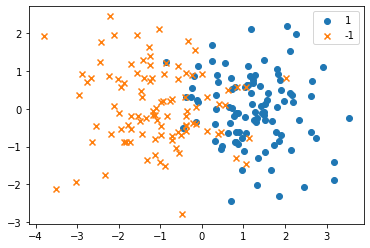

In [143]:
plt.scatter(X1[:,0], X1[:,1], marker='o', label='1')
plt.scatter(X2[:,0], X2[:,1], marker='x', label='-1')
plt.legend()
plt.show()

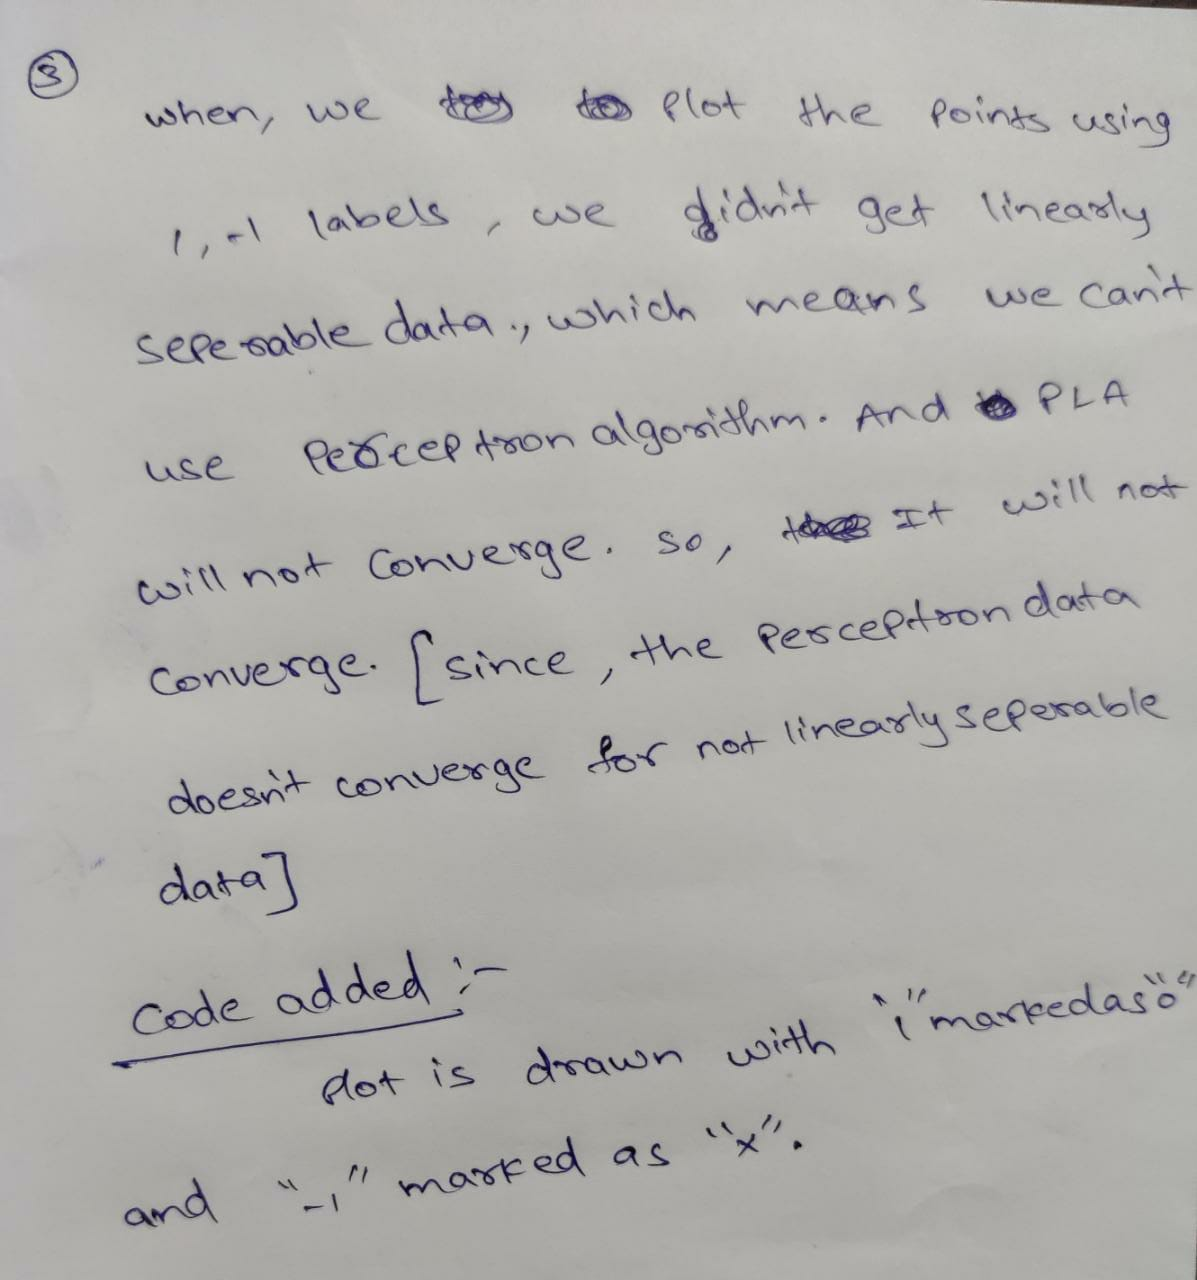



### Problem 4: Implementing Multilayer Perceptron and Backpropagation   **[30 marks]**

In this problem, we will be using [MNIST dataset](http://yann.lecun.com/exdb/mnist/) of handwritten digits for classification task. A data folder that will be useful for doing this problem has been provided to you along with this notebook.

Let us load the data first (it has been done for you).

In [144]:
import numpy as np
np.random.seed(0)

## Load the training data from the data folder
output_dim = 10
x_train = np.load('./data/X_train.npy')
x_train = x_train.flatten().reshape(-1,28*28)
x_train = x_train / 255.0
x_train = x_train.T
gt_indices = np.load('./data/y_train.npy')
train_length = x_train.shape[1]

#creating one hot vector representation
y_train = np.zeros((train_length, output_dim))
for i in range(train_length):
    y_train[i,gt_indices[i]] = 1
y_train = y_train.T
print("Number of training examples: {:d}".format(train_length))

## Loading the test data
x_test = np.load('./data/X_test.npy')
x_test = x_test.flatten().reshape(-1,28*28)
x_test = x_test / 255.0
x_test = x_test.T
gt_indices = np.load('./data/y_test.npy')
test_length = x_test.shape[1]

#creating one hot vector representation
y_test = np.zeros((test_length, output_dim))
for i in range(test_length):
    y_test[i,gt_indices[i]] = 1
y_test = y_test.T
print("Number of test examples: {:d}".format(test_length))

Number of training examples: 60000
Number of test examples: 10000


This problem considers neural networks with multiple layers. Each layer has multiple inputs and outputs, and can be broken down into two parts:  

A linear module that implements a linear transformation:     $ z_j = (\sum^{m}_{i=1} x_i W_{i,j}) + {W_0}_j$  
specified by a weight matrix $W$ and a bias vector $W_0$. The output is $[z_1, \ldots, z_n]^T$

An activation module that applies an activation function to the outputs of the linear module for some activation function $f$, such as Tanh or ReLU in the hidden layers or Softmax at the output layer. We write the output as: $[f(z_1), \ldots, f(z_m)]^T$, although technically, for some activation functions such as softmax, each output will depend on all the $z_i$.

We will use the following notation for quantities in a network:
- Inputs to the network are $x_1,..., x_d$
- Number of layers is $L$
- There are $m^l$ inputs to layer $l$
- There are $n^l = m^{l+1}$ outputs from layer $l$
- The weight matrix for layer $l$ is $W^l$, an $m^l \times n^l$ matrix, and the bias vector (offset) is $W_0^l$, an $n^l \times 1$ vector
- The outputs of the linear module for layer $l$ are known as pre-activation values and denoted $z^l$
- The activation function at layer $l$ is $f^l(\cdot)$
- Layer $l$ activations are $a^l = [f^l(z^l_1), \ldots, f^l(z^l_{n^l})]^T$
- The output of the network is the values $a^L = [f^L(z^L_1), \ldots, f^L(z^L_{n^L})]^T$
- Loss function $Loss(a,y)$ measures the loss of output values $a$ when the target is $y$


We'll use the modular implementation, which leads to clean code. The basic framework for SGD training is given below. We can construct a network and train it as follows:

```
# build a 3-layer network
net = Sequential([Linear(2,3), Tanh(),
                  Linear(3,3), Tanh(),
    	          Linear(3,2), SoftMax()])
# train the network on data and labels
net.sgd(x_train, y_train)
```
Please fill in any unimplemented methods below:

## Linear Modules: ##
Each linear module has a forward method that takes in a batch of activations A (from the previous layer) and returns a batch of pre-activations Z; ; it can also store its input or output vectors for use by other methods (e.g., for subsequent backpropagation).

$Z = W^T A + W_0$

Each linear module has a backward method that takes in a column vector dLdZ and returns dLdA. This module also computes and stores dLdW and dLdW0, the gradients with respect to the weights.

$\frac{\partial Loss}{\partial A} = \frac{\partial Z}{\partial A} \frac{\partial Loss}{\partial Z}$ and similarly.

In [145]:
class Module:
    def sgd_step(self, lrate): 
        pass # For modules without weights

class Linear(Module):
    def __init__(self, m, n):
        self.m, self.n = (m, n)  # (in size, out size)
        self.W0 = np.zeros([self.n, 1])  # (n x 1)
        self.W = np.random.normal(0, 1.0 * m ** (-.5), [m, n])  # (m x n)

    def forward(self, A):
        self.A = A   # (m x b)  b is the batch size, which is 1 for SGD
        return np.dot(self.W.T,self.A)+self.W0  ## ! -- code required # (n x b)

    def backward(self, dLdZ):  # dLdZ is (n x b), uses stored self.A
        ## ! -- code required
        self.dLdW = np.dot(self.A,dLdZ.T)       # (m x n)
        self.dLdW0 = dLdZ      # (n x 1)
        return np.dot(self.W,dLdZ)           # return dLdA (m x b)

    def sgd_step(self, lrate):  # Gradient descent step
        ## ! -- code required
        self.W = self.W-lrate*self.dLdW           
        self.W0 = self.W0-lrate*self.dLdW0          

## Activation functions: ##
Activation modules don't have any weights and so they are simpler.

Each activation module has a forward method that takes in a batch of pre-activations Z and returns a batch of activations A.

Each activation module has a backward method that takes in dLdA and returns dLdZ, with the exception of SoftMax, where we assume dLdZ is passed in.

$\frac{\partial Loss}{\partial Z} = \frac{\partial Loss}{\partial A} \frac{\partial A}{\partial Z}$

For Softmax = $SM(Z)$ at the output layer and cross entropy as the $Loss(A,Y)$ function, there is a [simple form](https://peterroelants.github.io/posts/cross-entropy-softmax/) for ${\tt dLdZ} = \frac{\partial Loss}{\partial Z}$; namely, it is the prediction error $A−Y$. 

### Tanh: ###

In [146]:
class Tanh(Module):            # Layer activation
    def forward(self, Z):
        self.A = np.tanh(Z)
        return self.A

    def backward(self, dLdA):    # Uses stored self.A
        return (1-self.A**2)*dLdA  ## ! -- code required # return dLdZ (?, b)

### ReLU: ###

In [147]:
class ReLU(Module):              # Layer activation
    def forward(self, Z):
        self.A = np.where(Z < 0, 0, Z)  ## ! -- code required # (?, b)
        return self.A

    def backward(self, dLdA):    # uses stored self.A
        dAdZ=np.where(self.A > 0, 1, self.A)
        return np.multiply(dAdZ,dLdA)  ## ! -- code required # return dLdZ (?, b)

### SoftMax: ###
For `SoftMax.class_fun()`, given the column vector of class probabilities for each point (computed by Softmax), return a vector of the classes (integers) with the highest probability for each point.

In [148]:
class SoftMax(Module):           # Output activation
    def forward(self, Z):
	    expZ = np.exp(Z - np.max(Z))
	    return expZ / expZ.sum(axis=0, keepdims=True) ## ! -- code required # (?, b)

    def backward(self, dLdZ):    # Assume that dLdZ is passed in
        return dLdZ

    def class_fun(self, Ypred):  # Return class indices
        indices = Ypred.argmax(axis=0)
        return indices  ## ! -- code required # (1, b)

## Loss Function:##
Each loss module has a forward method that takes in a batch of predictions Ypred (from the previous layer) and labels Y and returns a scalar loss value.

The CrossE module has a backward method that returns dLdZ, the gradient with respect to the preactivation to SoftMax (note: not the activation!), since we are always pairing SoftMax activation with Cross Entropy loss

### Cross Entropy: ###

In [149]:
class CROSSE(Module):       # Loss
    def forward(self, Ypred, Y):
        self.Ypred = Ypred
        self.Y = Y
        loss = -(Y * np.log(Ypred+1e-8)).sum(axis=0)
        return loss  ## ! -- code required

    def backward(self):  # Use stored self.Ypred, self.Y
        dLdZ=np.subtract(self.Ypred,self.Y)
        return dLdZ  ## ! -- code required

## Neural Network: ##

Implement SGD. Randomly pick a data point Xt, Yt by using np.random.randint to choose a random index into the data. Compute the predicted output Ypred for Xt with the forward method. Compute the loss for Ypred relative to Yt. Use the backward method to compute the gradients. Use the sgd_step method to change the weights. Repeat.

Also, record the training accuracy after every 1000 iterations and plot it to show how the training accuracy changes with the number of iterations.

In [150]:
import matplotlib.pyplot as plt

class Sequential:
    def __init__(self, modules, loss):            # List of modules, loss module
        self.modules = modules
        self.loss = loss

    def sgd(self, X, Y, iters=100, lrate=0.005):  # Train
        D, N = X.shape
        accuracies = [] # for plotting
        itrns = [] # for plotting
        for it in range(iters):
            ## ! -- code required
            i=np.random.randint(low=0,high=X.shape[1])
            x_i=X[:,i].reshape(-1,1)
            y_i=Y[:,i].reshape(-1,1)
            Ypred=self.forward(x_i)
            z=self.loss.forward(Ypred,y_i)
            self.backward(self.loss.backward())
            self.sgd_step(lrate)
            if it % 1000 == 0 or it == iters-1:
                acc = self.get_accuracy(X, Y)
                accuracies.append(acc * 100)
                itrns.append(it)
                print('Iteration =', it, '\tTraining Accuracy = %.2f%%' % (acc * 100))
        ## ! -- code required
        plt.title("Iterations vs Accuracy")
        plt.plot(itrns,accuracies,marker='o')
        plt.show()
        # plot accuracy vs iteration with appropriate labelling

    def forward(self, Xt):                        # Compute Ypred
        for m in self.modules: 
            Xt = m.forward(Xt)
        return Xt

    def backward(self, delta):                    # Update dLdW and dLdW0
        # Note reversed list of modules
        for m in self.modules[::-1]: 
            delta = m.backward(delta)

    def sgd_step(self, lrate):                    # Gradient descent step
        for m in self.modules: 
            m.sgd_step(lrate)

    def get_accuracy(self, X, Y):
        # Method to print accuracy
        cf = self.modules[-1].class_fun
        acc = np.mean(cf(self.forward(X)) == cf(Y))
        return acc

Now, keeping the **number of hidden layers fixed at 2** and **learning rate fixed at 0.005** and the **number of iterations fixed at 17000**, try tuning the number of hidden units in each hidden layer as well as the activation function after every linear module. One example of a network having 30 hidden units in the first hidden layer followed by RELU activation and 20 in the second followed by Tanh activation is `nn = Sequential([Linear(input_dim, 30), ReLU(), Linear(30, 20), Tanh(), Linear(20,output_dim), SoftMax()], CROSSE())` 

Iteration = 0 	Training Accuracy = 10.24%
Iteration = 1000 	Training Accuracy = 69.32%
Iteration = 2000 	Training Accuracy = 79.94%
Iteration = 3000 	Training Accuracy = 84.82%
Iteration = 4000 	Training Accuracy = 86.80%
Iteration = 5000 	Training Accuracy = 86.91%
Iteration = 6000 	Training Accuracy = 88.56%
Iteration = 7000 	Training Accuracy = 88.63%
Iteration = 8000 	Training Accuracy = 88.93%
Iteration = 9000 	Training Accuracy = 88.50%
Iteration = 10000 	Training Accuracy = 90.07%
Iteration = 11000 	Training Accuracy = 89.64%
Iteration = 12000 	Training Accuracy = 90.22%
Iteration = 13000 	Training Accuracy = 90.99%
Iteration = 14000 	Training Accuracy = 91.20%
Iteration = 15000 	Training Accuracy = 90.99%
Iteration = 16000 	Training Accuracy = 91.71%
Iteration = 16999 	Training Accuracy = 91.82%


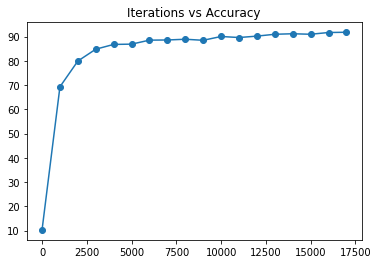

Test Acc = 0.9214


In [151]:
input_dim = 784  # input dimension
nn = Sequential([Linear(input_dim, 30), ReLU(), Linear(30, 20), Tanh(), Linear(20,output_dim), SoftMax()], CROSSE())  ## ! -- code required
nn.sgd(x_train, y_train, iters=17000, lrate=0.005)
test_acc = nn.get_accuracy(x_test, y_test)
print('Test Acc =', test_acc)

.

.

.

Wow, you made it this far. That is impressive. Congratulations!